<a href="https://colab.research.google.com/github/searchsolved/search-solved-public-seo/blob/main/create_bcg_matrix_from_ga_landing_page_report/create_bcg_matrix_from_ga_landing_page_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**How to Use: **

1.   Upload a GA Landing Page Report with Sessions & Revenue. 
2.   Lookup for a Chrome Popup asking to download multiple files at once.
3.   Done!

This script takes a landing page report and creates a BCG matric from the data. This is useful for spotting any outliers in the data. (For example, high revenue but low traffic? Strategise to increase the traffic - maybe run a paid campaign and so on).

The Output:
This script output a top level report from a custom starting URL depth, and then loops one level deeper. (e.g. it'll report on the parent category data and then loop through for each subcategory and generate an independant report for each).


In [ ]:
!pip install pandas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import io

from google.colab import files 
from glob import glob

In [ ]:
# set the url starting depth to make the charts - default = 2
url_depth = 2

# Set label text size and colour
text_size = 6
text_colour = "red"

# set quadrant names
top_left = 'Finders'
top_right = 'Keepers'
bottom_left = 'Losers'
bottom_right = 'Weepers'

# set the DPI Resolution for Export
dpi_size = 300

In [ ]:
# Upload the Landing Page Report from Google Analytics
uploaded = files.upload()

Saving Analytics DOS - MV - Annotations Organic Search Traffic 20210101-20210131 20200101-20200131.xlsx to Analytics DOS - MV - Annotations Organic Search Traffic 20210101-20210131 20200101-20200131.xlsx


In [ ]:
ga_filename=list(uploaded.keys())[0]  # get the filename from the upload
df_ga = pd.read_excel(ga_filename, 'Dataset1')  # choose the right sheet from Excel
print(df_ga.head())

                                        Landing Page  ...      Revenue
0                       /category/attic-widgets.html  ...  7950.154080
1                       /category/attic-widgets.html  ...  6013.269537
2                    /category/basement-widgets.html  ...  2360.359511
3                    /category/basement-widgets.html  ...  1586.040264
4  /category/attic-widgets/attic-glazed-widgets.html  ...  2396.614191

[5 rows x 11 columns]


In [ ]:
# Sense check the data and flag if < 100 rows imported from GA
count_rows = df_ga.shape[0]
print("Imported:", count_rows, "rows from Google Analytics")

if count_rows < 100:
    print("Under 100 Rows Imported, Did you export all rows?!")

Imported: 2228 rows from Google Analytics


# Clean the Data

In [ ]:
df_ga["Landing Page"] = df_ga["Landing Page"].astype(str)  # convert data types to string
df_ga["Folder"] = df_ga["Landing Page"].str.split("/").str[url_depth]  # Extract the Category Folder from a URL
df_ga["Folder Name"] = df_ga["Folder"].str.split(".").str[0]  # split on . to consolidate .html urls
df_ga["Folder Name"] = df_ga["Folder Name"].dropna()  # drop NaN Values
df_ga_grp = (df_ga.groupby("Folder Name").agg({"Sessions": sum, "Revenue": sum}).reset_index())  # group by category, sum sessions and revenue
count_group_rows = df_ga_grp.shape[0]  # get the count of the df (used for loop)
df_ga_grp = df_ga_grp.sort_values(by="Sessions", ascending=False)  # sort by sessions
df_ga_grp.replace({"": "delete-me-empty-row"}, inplace=True)  # replace whitespace with string for deletion  # todo do this more elegantly
df_ga_grp = df_ga_grp[~df_ga_grp["Folder Name"].isin(["delete-me-empty-row"])]  # delete the empty rows
folder_list = df_ga_grp["Folder Name"] # make list of folders to loop through
folder_list = list(folder_list)
df_ga_grp['Folder Name'] = df_ga_grp['Folder Name'].astype(str)
df_ga_grp['Folder Name'] = df_ga_grp['Folder Name'].str.replace("-", " ")
df_ga_grp['Folder Name'] = df_ga_grp['Folder Name'].str.title()  # Convert to Title Case
df_ga_grp['Max Sessions'] = df_ga_grp["Sessions"].max()  # calculate max values
df_ga_grp['Max Revenue'] = df_ga_grp["Revenue"].max()  # calculate max values
df_ga_grp['Average Sessions'] = 100 * df_ga_grp["Sessions"] / df_ga_grp['Max Sessions']  # calculate the average values
df_ga_grp['Average Revenue'] = 100 * df_ga_grp["Revenue"] / df_ga_grp['Max Revenue']
df_ga_grp['Z - Bubble Size'] = (df_ga_grp['Average Sessions'] / 100) * 10  # create the bubble size

# delete the helper columns
del df_ga_grp['Max Sessions']
del df_ga_grp['Max Revenue']
del df_ga_grp['Sessions']
del df_ga_grp['Revenue']

df_ga_grp = df_ga_grp.round(2)  # round to 0 decimal places

# start matplotlib

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

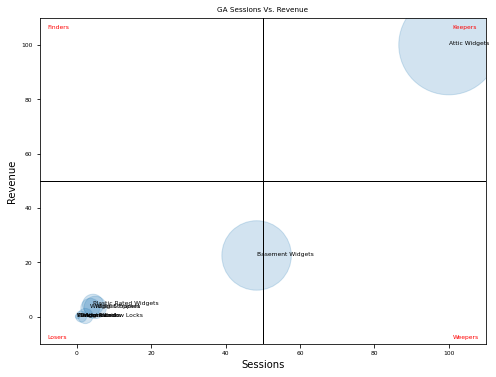

In [ ]:
# set the chart size (8 inch width vs 4 inch height)
plt.figure(figsize=(8,6))

# set font size
plt.rcParams.update({'font.size': 6})
plt.rcParams.update({'figure.autolayout': True})

# plot dataframe values
scat = plt.scatter(x=df_ga_grp['Average Sessions'],
            y=df_ga_grp['Average Revenue'],
            s=df_ga_grp['Z - Bubble Size'] * 1000,
            alpha=0.2)

# chart title and label axis
plt.title('GA Sessions Vs. Revenue')
plt.xlabel('Sessions', size=10)
plt.ylabel('Revenue', size=10)

# create main annotations
main_ann_list = []
for f, txt in enumerate(df_ga_grp['Folder Name']):
    main_ann = plt.annotate(txt, (df_ga_grp['Average Sessions'].iat[f], df_ga_grp['Average Revenue'].iat[f]))
    main_ann_list.append(main_ann)

    # Set x-axis range
    plt.xlim((-10,110))
    # Set y-axis range
    plt.ylim((-10,110))

    # Draw lines to split quadrants
    plt.plot([50,50],[-10,110], linewidth=0.5, color='black')
    plt.plot([-10,110],[50,50], linewidth=0.5, color='black')

# add labels to each quadrant
plt.text(-8, 106, top_left, size=text_size, color=text_colour)
plt.text(101, 106, top_right, size=text_size, color=text_colour)
plt.text(-8, -8, bottom_left, size=text_size, color=text_colour)
plt.text(101, -8, bottom_right, size=text_size, color=text_colour)

# save main four quadrant matrix chart
#plt.savefig('GA Sessions Vs. Revenue.png',dpi=dpi_size)
plt.savefig("GA Sessions Vs. Revenue - Depth - " + str(url_depth) + " - Main Export.png", dpi=dpi_size)
files.download("GA Sessions Vs. Revenue - Depth - " + str(url_depth) + " - Main Export.png")

In [ ]:
# remove annotations
for a in main_ann_list:
    a.remove()

scat.remove()  # remove scatter points
deep_depth = url_depth + 1  # add 1 to the url depth variable
df_ga["Folder"] = df_ga["Landing Page"].str.split("/").str[deep_depth]  # Extract the Category Folder from a URL + 1 level deeper
df_ga["Folder"] = df_ga["Folder"].str.replace(".html","")  # replace .html with "" for better grouping
count_group_rows = count_group_rows -1  # start looping through +1 level deeper

# Loop Through URL Folder Level Deeper & Save the Result PNGs
Remember to allow Chrome to download multiple files at once!

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

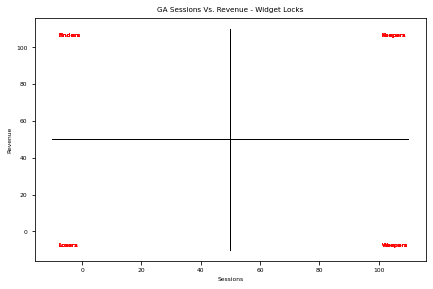

In [ ]:
i = 0
while i < count_group_rows:
    df2 = df_ga[df_ga["Folder Name"].isin([(folder_list[i])])]

    # clean up the list formatting for writing out to the .PNG (changed back at end of loop for matching each i)
    folder_list = [word.replace('-', ' ') for word in folder_list]
    folder_list = [word.title() for word in folder_list]

    # delete pagination and filter rows
    df2 = df2[~df2["Folder"].str.contains("page", na=False)]
    df2 = df2[~df2["Folder"].str.contains("=", na=False)]

    # group the df
    df2_grp = df2.groupby("Folder").agg({"Sessions":sum,"Revenue":sum}).reset_index()

    # calculate max values
    df2_grp['Max Sessions'] = df2_grp["Sessions"].max()
    df2_grp['Max Revenue'] = df2_grp["Revenue"].max()

    # calculate the average values
    df2_grp['Average Sessions'] = 100 * df2_grp["Sessions"] / df2_grp['Max Sessions']
    df2_grp['Average Revenue'] = 100 * df2_grp["Revenue"] / df2_grp['Max Revenue']

    df2_grp['Average Revenue'] = df2_grp['Average Revenue'].fillna(0)
    df2_grp['Average Sessions'] = df2_grp['Average Sessions'].fillna(0)

    # create the bubble size
    df2_grp['Z - Bubble Size'] = (df2_grp['Average Sessions'] / 100) * 10

    # delete the helper columns
    del df2_grp['Max Sessions']
    del df2_grp['Max Revenue']
    del df2_grp['Sessions']
    del df2_grp['Revenue']

    # round to 0 decimal places
    df2_grp = df2_grp.round(2)

    # replace '-' with ''
    df2_grp['Folder'] = df2_grp['Folder'].str.replace("-", " ")
    df2_grp['Folder'] = df2_grp['Folder'].str.title()

    rows = df2_grp['Folder'].count()

    # only export .csv files with more than 2 rows
    if rows >2:
        ann_list = []  # empty list that the annotation will go in
        # plot dataframe values
        scat = plt.scatter(x=df2_grp['Average Sessions'],
                    y=df2_grp['Average Revenue'],
                    s=df2_grp['Z - Bubble Size'] * 1000,
                    alpha=0.5)

        # chart title and label axis
        plt.title('GA Sessions Vs. Revenue' + " - " + folder_list[i])
        plt.xlabel('Sessions')
        plt.ylabel('Revenue')

      # Draw lines to split quadrants
        plt.plot([50,50],[-10,110], linewidth=0.5, color='black')
        plt.plot([-10,110],[50,50], linewidth=0.5, color='black')

      # add labels to each quadrant
        plt.text(-8, 106, top_left, size=text_size, color=text_colour)
        plt.text(101, 106, top_right, size=text_size, color=text_colour)
        plt.text(-8, -8, bottom_left, size=text_size, color=text_colour)
        plt.text(101, -8, bottom_right, size=text_size, color=text_colour)

        for g, txt in enumerate(df2_grp['Folder']):
            ann = plt.annotate(txt, (df2_grp['Average Sessions'].iat[g], df2_grp['Average Revenue'].iat[g]), horizontalalignment='center', size="4")
            ann_list.append(ann)

        # make list title case for file export
        title_folder_list = [word.title() for word in folder_list]

        plt.savefig('GA Sessions Vs. Revenue - Depth - ' + str(deep_depth) + " - " + title_folder_list[i] + ".png", dpi=dpi_size)
        files.download("GA Sessions Vs. Revenue - Depth - " + str(deep_depth) + " - " + title_folder_list[i] + ".png")
        for a in ann_list:
            a.remove()
        scat.remove()  # remove scatter points

    else:
        break

    # change the folder name back for matching in the loop
    df2_grp['Folder'] = df2_grp['Folder'].str.replace(" ", "-")
    df2_grp['Folder'] = df2_grp['Folder'].str.lower()
    folder_list = [word.replace(' ', '-') for word in folder_list]
    folder_list = [word.lower() for word in folder_list]

    # update the counter each loop
    i = i + 1